# k-Nearest Neighbors (kNN) Algorithm Implementation


## Theory 
* Is a non-probabilistic, non-parametric and instance-based learning algorithm:
    * **Non-parametric** means it makes no explicit assumptions about the function form of _h_, avoiding the dangers of mis-modelling the underlying distribution of the data.
    * **Instance-based** means that the algorithm doesn't explicitly learn a model. Instead, it chooses to memorize the training instances which are subsequently used as "knowledge" for the prediction phase.
* The algorithm is simple and robust, and it is often used as a benchmark for more complex classifiers such as Artificial Neural Networks (ANN) and Support Vector Machines (SVM).

### Pros 
* **Simple** to understand and implement with **little to zero training time**
* kNN **works just as easily with multi-class data** sets whereas other algorithms are hard-coded for the binary setting the non-parametric nature of kNN gives it an edge in certain settings where the data may be highly unusual, thus **without prior knowledge on distribution**

### Cons
* **computationally expensive** testing phase
    * we **need to store the whole data set for each decision**!
* can **suffer from skewed class distributions**
    * The accuracy can be severally **degraded with high-dimension data** because of the little difference between the nearest and farthest neighbor
    * **The curse of dimensionality** refers to various phenomena that arise when analyzing and organizing data in high-dimensional spaces that do not occur in low-dimensional settings such as the three-dimensional physical space of everyday experience
    * for high-dimensional data (e.g., with number of dimensions more than 10) **scaling** and **dimension reductions** (such as PCA) is usually performed prior applying kNN

## Classification<a name="clas"/> 

In [1]:
import logging

# Set up logging
logging.basicConfig(filename='knn.log', level=logging.INFO,
                    format="%(asctime)s:%(levelname)s:%(message)s", filemode='w')



In [2]:
# importing necessary libraries

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

logging.info('Neccessary packages installed successful')

In [3]:
# Use vector drawing inside jupyter notebook
%config InlineBackend.figure_format = "svg"

# Set matplotlib default axis font size (inside this notebook)
plt.rcParams.update({'font.size': 8})

logging.info('setting the font-size and vector drawing')

Load the data

In [4]:
# Load the Iris dataset from sklearn
iris = datasets.load_iris()

# Convert the dataset into a Pandas DataFrame for easier manipulation
df = pd.DataFrame(iris.data, columns=iris.feature_names)  

# Add the target (species label) to the DataFrame
df = df.assign(target=iris.target)  

logging.info('Data load Successful')

In [5]:
# Display the first 5 rows of the DataFrame
print(df.head())

logging.info('Display first few rows of dataset')

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [6]:
# check missing values
print(df.isnull().sum())  

logging.info('Checking missing values')  

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64


Show data summary: extend the `describe` method by selected stats

In [7]:
# Create a DataFrame to store column data types
dfinfo = pd.DataFrame(df.dtypes, columns=["dtypes"])  

# Compute selected statistics (count of non-null values and missing values)
for (m, n) in zip([df.count(), df.isna().sum()], ["count", "isna"]):
    dfinfo = dfinfo.merge(pd.DataFrame(m, columns=[n]),  
                          right_index=True, left_index=True, how="inner")  

# Concatenate the `describe()` output to dfinfo for additional statistical insights
dfinfo = pd.concat([dfinfo.T, df.describe().T], axis=0)
print(dfinfo)

logging.info('preprocessing the data')

                  sepal length (cm) sepal width (cm) petal length (cm)  \
dtypes                      float64          float64           float64   
count                           150              150               150   
isna                              0                0                 0   
sepal length (cm)               NaN              NaN               NaN   
sepal width (cm)                NaN              NaN               NaN   
petal length (cm)               NaN              NaN               NaN   
petal width (cm)                NaN              NaN               NaN   
target                          NaN              NaN               NaN   

                  petal width (cm) target  count      mean       std  min  \
dtypes                     float64  int32    NaN       NaN       NaN  NaN   
count                          150    150    NaN       NaN       NaN  NaN   
isna                             0      0    NaN       NaN       NaN  NaN   
sepal length (cm)        

Show histogram (distribution)

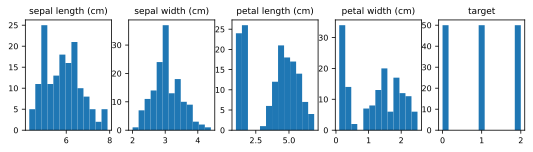

In [8]:
# Set figure size for better readability
plt.figure(figsize=(9, 2))  

# Iterate over each column in the DataFrame to create histograms
for (i, v) in enumerate(df.columns):  
    plt.subplot(1, df.shape[1], i + 1)  # Create subplots in a single row
    plt.hist(df.iloc[:, i], bins="sqrt")  # Use the square root rule for bin count
    plt.title(df.columns[i], fontsize=9)  # Set title with a smaller font size

# Display the plot
plt.show()

logging.info('Display distribution of data')

Displaying correlation matrix

In [9]:
# Compute the correlation matrix, rounding to 2 decimal places
df.corr().round(2).style.background_gradient(cmap="viridis")

logging.info('confusion matrix')

Scale and try to **reduce dimensions**: what we try to do is to **always simply the model** if possible (see correlation matrix above)
* More complex model (e.g., more features, or higher _*k*_) will (in theory) increase the probability of higher "out of sample" error (even when "in sample" error = train set) will be smaller!
* Use either 99% threshold (own subjective) or "mle" algorithm (more objective)
* Use **linear** scaler (transformation)
* The data is scaled prior train-test split. 
    * In real applications, first split and scale afterwards, to simulate real-world scenario where we do not have the test set! (otherwise data snooping effect)

In [11]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler with mean and standard deviation normalization
scale = StandardScaler(with_mean=True, with_std=True)

# Apply transformation: Standardize features (excluding the target column)
Xo = scale.fit_transform(df.drop(["target"], axis=1).values)



In [12]:
from sklearn.decomposition import PCA

# Apply PCA with 99% variance retention
pca = PCA(n_components=0.99)  # Or set n_components="mle"

# Transform the standardized features
X = pca.fit_transform(Xo)

# Print the number of selected components vs. original features
print("Nr. of features after PCA = {} (input = {})".format(X.shape[1], Xo.shape[1]))

logging.info('fit the model')

Nr. of features after PCA = 3 (input = 4)


Prepare Data for fitting the model

In [16]:
# encode target values (is not necessary for IRIS but still:-)
y = LabelEncoder().fit_transform(df["target"].values);

# Split 2/3 to 1/3 train to test respectively
[X_train,X_test,y_train,y_test] = train_test_split(X,y,train_size = 0.67,test_size = 0.33,
                                                   stratify=y,random_state=123);

#### Find optimal model
* Considering the small data set (150 samples), find "optimal" k setting it to maximum of 5
    * Optimal in terms of accuracy
    * Simple model = higher probability of lower in and out-of sample error

In [17]:
logging.info('optimal model find')

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the KNN model
model = KNeighborsClassifier(algorithm="auto")

# Define the hyperparameter grid
parameters = {
    "n_neighbors": [1, 3, 5],  # Number of neighbors to consider
    "weights": ["uniform", "distance"]  # Weighting method for neighbors
}

# Perform grid search with 5-fold cross-validation
model_optim = GridSearchCV(model, parameters, cv=5, scoring="accuracy")


In [19]:
# Fit the model to the training data
model_optim.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Display the "optimal" settings for kNN

In [20]:
# Display the best hyperparameters
print("Best hyperparameters:", model_optim.best_params_)


Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform'}


In [21]:
# Display the best accuracy score
print("Best accuracy score:", model_optim.best_score_)
print("Best accuracy score:", model_optim.score(X_test, y_test))


Best accuracy score: 0.95
Best accuracy score: 0.96


#### Display Classification Report 

In [66]:
# Loop through Train and Test datasets and print the classification report
for i, (x, y) in zip(["Train", "Test"], [(X_train, y_train), (X_test, y_test)]):
    print(f"Classification kNN {i} report:\n", classification_report(y, model_optim.predict(x)))


Classification kNN Train report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        33

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Classification kNN Test report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.88      0.94        17
           2       0.89      1.00      0.94        17

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



In [22]:
logging.info('display classification report')

In this case, the precision (accuracy=macro avg precision) is very high. 
Just to show that that is not coincidence compare to "dummy" model (most frequent & uniform distribution)

In [23]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Loop through different dummy strategies
for strategy in ["most_frequent", "uniform"]:
    dummy = DummyClassifier(strategy=strategy).fit(X_train, y_train)
    y_pred = dummy.predict(X_test)  # Get predictions
    print(f"\nClassification '{strategy}' test report:\n", classification_report(y_test, y_pred))



Classification 'most_frequent' test report:
               precision    recall  f1-score   support

           0       0.32      1.00      0.48        16
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        17

    accuracy                           0.32        50
   macro avg       0.11      0.33      0.16        50
weighted avg       0.10      0.32      0.16        50


Classification 'uniform' test report:
               precision    recall  f1-score   support

           0       0.31      0.25      0.28        16
           1       0.39      0.53      0.45        17
           2       0.36      0.29      0.32        17

    accuracy                           0.36        50
   macro avg       0.35      0.36      0.35        50
weighted avg       0.35      0.36      0.35        50



## Regression 
* Predicts value as the **average of the values** of its k nearest neighbors

Loading the data

In [25]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

# Load the California housing dataset
house = fetch_california_housing()

# Create a DataFrame with feature names
housing_data = pd.DataFrame(house.data, columns=house.feature_names)

# Add the target variable (median house value)
housing_data["Target"] = house.target  

# Display the first few rows
housing_data.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [26]:
logging.info('Regression Analysis')

Inspect data: show statistics, histogram and correlation 

In [27]:
import pandas as pd

# Create a DataFrame for column data types
dfinfo = pd.DataFrame(housing_data.dtypes, columns=["dtypes"])

# Add count of non-null values and missing values
for metric, name in zip([housing_data.count(), housing_data.isna().sum()], ["count", "missing"]):
    dfinfo = dfinfo.merge(metric.rename(name).to_frame(), 
                          right_index=True, left_index=True, how="inner")

# Combine with `describe()` output
df_summary = pd.concat([dfinfo.T, housing_data.describe()], axis=0)

# Display the summary
df_summary


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
dtypes,float64,float64,float64,float64,float64,float64,float64,float64,float64
count,20640,20640,20640,20640,20640,20640,20640,20640,20640
missing,0,0,0,0,0,0,0,0,0
count,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0
mean,3.870671,28.639486,5.429,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.38605,2.135952,2.003532,1.153956
min,0.4999,1.0,0.846154,0.333333,3.0,0.692308,32.54,-124.35,0.14999
25%,2.5634,18.0,4.440716,1.006079,787.0,2.429741,33.93,-121.8,1.196
50%,3.5348,29.0,5.229129,1.04878,1166.0,2.818116,34.26,-118.49,1.797
75%,4.74325,37.0,6.052381,1.099526,1725.0,3.282261,37.71,-118.01,2.64725


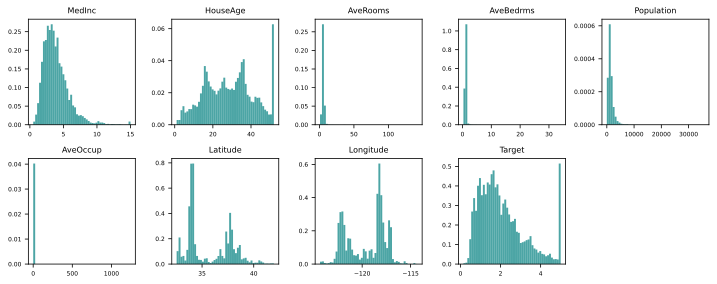

In [28]:
import matplotlib.pyplot as plt

# Determine the number of columns
num_cols = len(housing_data.columns)

# Compute the number of rows dynamically (5 plots per row)
num_rows = -(-num_cols // 5)  # Equivalent to math.ceil(num_cols / 5)

plt.figure(figsize=(10, 2 * num_rows))

# Loop through each column and plot
for i, col in enumerate(housing_data.columns):
    plt.subplot(num_rows, 5, i + 1)
    plt.hist(housing_data[col], bins=50, density=True, alpha=0.7, color='teal')
    plt.title(col, fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()


In [29]:
# Compute the correlation matrix
corr_matrix = housing_data.corr().round(2)

# Display with a background gradient
styled_corr = corr_matrix.style.background_gradient(cmap="viridis")

# Show in Jupyter Notebook
display(styled_corr)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
MedInc,1.000000,-0.120000,0.330000,-0.060000,0.000000,0.020000,-0.080000,-0.020000,0.690000
HouseAge,-0.120000,1.000000,-0.150000,-0.080000,-0.300000,0.010000,0.010000,-0.110000,0.110000
AveRooms,0.330000,-0.150000,1.000000,0.850000,-0.070000,-0.000000,0.110000,-0.030000,0.150000
AveBedrms,-0.060000,-0.080000,0.850000,1.000000,-0.070000,-0.010000,0.070000,0.010000,-0.050000
Population,0.000000,-0.300000,-0.070000,-0.070000,1.000000,0.070000,-0.110000,0.100000,-0.020000
AveOccup,0.020000,0.010000,-0.000000,-0.010000,0.070000,1.000000,0.000000,0.000000,-0.020000
Latitude,-0.080000,0.010000,0.110000,0.070000,-0.110000,0.000000,1.000000,-0.920000,-0.140000
Longitude,-0.020000,-0.110000,-0.030000,0.010000,0.100000,0.000000,-0.920000,1.000000,-0.050000
Target,0.690000,0.110000,0.150000,-0.050000,-0.020000,-0.020000,-0.140000,-0.050000,1.000000


#### Supervised Reduction
* Considering the correlation, histogram and the summary table:
    * Remove/drop "AveOccup" (average house occupancy)

In [30]:
housing_data = housing_data.drop(["AveOccup"],axis=1)

In [31]:
housing_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,37.85,-122.25,3.422


Prepare for fitting by scaling data set
* Here, the data is scaled prior train-test split. 
    * In real applications, first split and scale afterwards, to simulate real-world scenario where we do not have the test set!

In [32]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler with mean and standard deviation normalization
scale = StandardScaler(with_mean=True, with_std=True)

# Apply transformation: Standardize features (excluding the target column)
Xo = scale.fit_transform(housing_data.drop(["Target"], axis=1).values)



In [33]:
from sklearn.decomposition import PCA

# Apply PCA with 99% variance retention
pca = PCA(n_components=0.99)  # Or set n_components="mle"

# Transform the standardized features
X = pca.fit_transform(Xo)

# Print the number of selected components vs. original features
print("Nr. of features after PCA = {} (input = {})".format(X.shape[1], Xo.shape[1]))


Nr. of features after PCA = 6 (input = 7)


#### Fit the model and predict

In [34]:
# Split the data into training and testing sets
[X_train, X_test, y_train, y_test] = train_test_split(X, housing_data["Target"], 
                                                      train_size=0.67, test_size=0.33, random_state=123)


In [35]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize the KNN model
knn_model = KNeighborsRegressor(algorithm="auto")

# Define the hyperparameter grid
parameters = {
    "n_neighbors": [1, 3, 5],  # Number of neighbors to consider
    "weights": ["uniform", "distance"]  # Weighting method for neighbors
}

# Perform grid search with 5-fold cross-validation
knn_model_optim = GridSearchCV(knn_model, parameters, cv=5, scoring="neg_mean_squared_error")


In [36]:
# Fit the model to the training data
knn_model_optim.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 3, 5],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [37]:
# Display the best hyperparameters
print("Best hyperparameters:", knn_model_optim.best_params_)    

Best hyperparameters: {'n_neighbors': 5, 'weights': 'distance'}


In [38]:
print("Regression kNN (test) RMSE \t= {:.0f} *1000$".format(
    100*np.sqrt(mean_squared_error(knn_model_optim.predict(X_test),y_test))))

Regression kNN (test) RMSE 	= 67 *1000$


Compare to dummy

In [39]:
# Loop through Train and Test datasets and print the classification report
for i, (x, y) in zip(["Train", "Test"], [(X_train, y_train), (X_test, y_test)]):
    print(f"Regression kNN {i} RMSE \t= {np.sqrt(mean_squared_error(knn_model_optim.predict(x),y)):.0f} *1000$")
    
import warnings
warnings.filterwarnings("ignore")


Regression kNN Train RMSE 	= 0 *1000$
Regression kNN Test RMSE 	= 1 *1000$


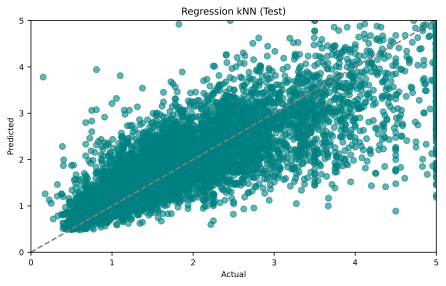

In [95]:
# Visualize the clssification and regresion results
plt.figure(figsize=(12, 4))

# Plot the actual vs. predicted values for the test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, knn_model_optim.predict(X_test), color="teal", alpha=0.6)
plt.plot([0, 5], [0, 5], "--", color="gray")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Regression kNN (Test)")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.tight_layout()
plt.show()


In [40]:
# Save the dataset to an Excel file
housing_data.to_excel('housing_data.xlsx', index=False)

logging.info('Dataset saved to Excel file')